# Kubios HRV analyysi

Fysiologiset mittaukset ja anturit 2022<br>
Sakari Lukkarinen ja Saana Vallius<br>
Metropolia Ammattikorkeakoulu

Perustuu esimerkkeihin:

- [Kubioscloud example for Authorization code grant](https://bitbucket.org/kubios/workspace/snippets/4X95xd/kubioscloud-example-for-authorization-code)
- [KubiosCloud Client](https://bitbucket.org/kubios/kub-kubioscloud-cli/src/master/)

Katso myös: 
- [KubiosCloud API Documentation](https://analysis.kubioscloud.com/v1/portal/documentation/apis.html#kubioscloud-api-reference)

## Asetukset

Luetaan tarvittavat kirjastot.

In [1]:
#!/usr/bin/env python3
import numpy as np
import requests

DEBUG = False

## Avaimet

Avaimet löytyvät erillisestä työtilan dokumentista.

KubiosCloud API dokumentaation kohdassa [Analytics Endpoint](https://analysis.kubioscloud.com/v1/portal/documentation/apis.html#analytics-endpoint) on kerrottu, että kaikki tämän kohdan toiminnot vaativat toimiakseen APIKEY autentikoinnin. Siksi alla on APIKEY -avaimet.

In [2]:
APIKEY = ""
CLIENT_ID = ""
CLIENT_SECRET = ""

LOGIN_URL = "https://kubioscloud.auth.eu-west-1.amazoncognito.com/login"
TOKEN_URL = "https://kubioscloud.auth.eu-west-1.amazoncognito.com/oauth2/token"
REDIRECT_URI = "https://analysis.kubioscloud.com/v1/portal/login"

## Sisäänpääsyvaltuudet

Seurataan suoraan esimerkkejä kuinka saadaan sisäänpääsyvaltuudet (access token).

In [3]:
response = requests.post(
    url = TOKEN_URL, 
    data = {'client_id': CLIENT_ID, 'grant_type': 'client_credentials'}, 
    auth = (CLIENT_ID, CLIENT_SECRET)).json()
access_token = response["access_token"]

if DEBUG:
    print(access_token)

## Avataan istunto (session)

Muodostetaan `requests` istunto, jolle on annettu vaadittava API avain ja sisäänpääsyvaltuudet.

In [4]:
headers = {
    "Authorization": "Bearer {}".format(access_token),
    "X-Api-Key": APIKEY,
}
reqs = requests.Session()
reqs.headers.update(headers)

if DEBUG:
    print(headers)

## Lue hrv data tiedostosta ja muodosta datasetti

Luetaan Biopac EKG-signaalista laskettu RR-intervallidata ja muodostetaan KubiosCloudin ymmärtämä json muotoinen datasetti.

In [5]:
# Lue HRV data
data = np.genfromtxt('hrv_data.csv', skip_header = 1).squeeze().tolist()

if DEBUG:
    print(data)

In [6]:
# Muodosta data_set
data_set = {"format": "RR",
            "data": [
                { "values": data} ] }
if DEBUG:
    print(data_set)

## HRV analyysi

Kutsutaan KubiosCloudin readiness analyysia käyttäen muodostettua dataa. Data annetaan `requests` metodin `json`kenttään. Tuloksena saadaan `response`, joka näytetään json-muodossa.

In [7]:
# Make the readiness analysis with the given data
response = reqs.request('POST', 
                        url = "https://analysis.kubioscloud.com/v1/analytics/readiness",
                        params = None, 
                        json = data_set).json()
print(response)

{'analysis': {'artefact': 2.8332823225919275, 'artefact_level': 'GOOD', 'create_timestamp': '2023-02-01T20:08:40.649328+00:00', 'freq_domain': {'HF_peak': 0.16666666666666666, 'HF_power': 1398.4412111123454, 'HF_power_nu': 10.81498955001239, 'HF_power_prc': 10.404032925912812, 'LF_HF_power': 8.245714133188896, 'LF_peak': 0.1, 'LF_power': 11531.146458902862, 'LF_power_nu': 89.17731218282738, 'LF_power_prc': 85.78868133936189, 'VLF_peak': 0.04, 'VLF_power': 510.7547060456089, 'VLF_power_prc': 3.7998799924786653, 'tot_power': 13441.337806893294}, 'mean_hr_bpm': 93.3623443230236, 'mean_rr_ms': 642.6573843562292, 'pns_index': -0.8901703957732948, 'readiness': 62.5, 'respiratory_rate': 14.81, 'rmssd_ms': 59.165619340626556, 'sd1_ms': 41.93493665168639, 'sd2_ms': 120.85835498737853, 'sdnn_ms': 90.32084588745668, 'sns_index': 1.534449148664106, 'stress_index': 7.29614165035525}, 'status': 'ok'}


Poimitaan analysis-rakenne ja näytetään siitä muutamia analyysituloksia.

In [8]:
analysis = response['analysis']

print(f"mean_hr_bpm:      {analysis['mean_hr_bpm']:4.0f}")
print(f"mean_rr_ms:       {analysis['mean_rr_ms']:4.0f}")
print(f"rmssd_ms:         {analysis['rmssd_ms']:4.0f}")
print(f"respiratory_rate: {analysis['respiratory_rate']:5.1f}")
print(f"sns_index:        {analysis['sns_index']:5.2f}")
print(f"pns_index:        {analysis['pns_index']:5.2f}")

mean_hr_bpm:        93
mean_rr_ms:        643
rmssd_ms:           59
respiratory_rate:  14.8
sns_index:         1.53
pns_index:        -0.89


## Lisäasetukset

Näitä kirjastoja tarvitaan visualisointia ja tulosten tarkastelua varten

In [9]:
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt

## Muunnetaan tulos DataFrameksi

Muunnetaan tulos pandasin DataFrameksi [json_normalize](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.json_normalize.html) metodilla ja näytetään se [transpose](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transpose.html)-muodossa.

In [10]:
dataframe = pd.json_normalize(response)
pprint(dataframe.T)

                                                                   0
status                                                            ok
analysis.artefact                                           2.833282
analysis.artefact_level                                         GOOD
analysis.create_timestamp           2023-02-01T20:08:40.649328+00:00
analysis.freq_domain.HF_peak                                0.166667
analysis.freq_domain.HF_power                            1398.441211
analysis.freq_domain.HF_power_nu                            10.81499
analysis.freq_domain.HF_power_prc                          10.404033
analysis.freq_domain.LF_HF_power                            8.245714
analysis.freq_domain.LF_peak                                     0.1
analysis.freq_domain.LF_power                           11531.146459
analysis.freq_domain.LF_power_nu                           89.177312
analysis.freq_domain.LF_power_prc                          85.788681
analysis.freq_domain.VLF_peak     

### Lisätietoa

- [Kubios HRV analysis methods](https://www.kubios.com/hrv-analysis-methods/)

## Näytä PNS ja SNS indeksit

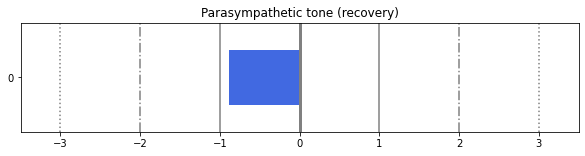

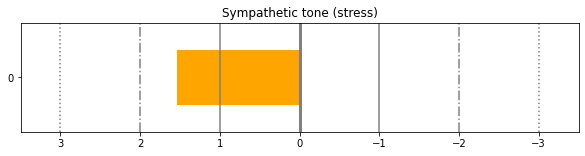

In [11]:
pns_index = dataframe['analysis.pns_index']
sns_index = dataframe['analysis.sns_index']

def add_lines():
    plt.axvline(0, color = 'gray', lw = 3)
    plt.axvline(-1, color = 'gray')
    plt.axvline(+1, color = 'gray')
    plt.axvline(-2, color = 'gray', ls = '-.')
    plt.axvline(+2, color = 'gray', ls = '-.')
    plt.axvline(-3, color = 'gray', ls = ':')
    plt.axvline(+3, color = 'gray', ls = ':')

fig = plt.figure(figsize = (10, 2))
pns_index.plot.barh(bottom = 5, color = 'royalblue')
plt.title('Parasympathetic tone (recovery)')
plt.xlim(-3.5, +3.5)
add_lines()

fig = plt.figure(figsize = (10, 2))
sns_index.plot.barh(color = 'orange')
plt.title('Sympathetic tone (stress)')
plt.xlim(3.5, -3.5)
add_lines()

plt.show()

### Lisätietoa

- [HRV in evaluating ANS function](https://www.kubios.com/hrv-ans-function/)

## Näytä taajuusalueiden tehot

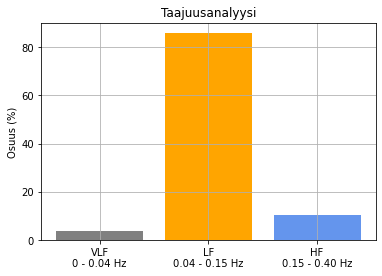

In [12]:
# Näytä taajuusalueiden tehot
vlf_power = dataframe['analysis.freq_domain.VLF_power_prc'].values
lf_power = dataframe['analysis.freq_domain.LF_power_prc'].values
hf_power = dataframe['analysis.freq_domain.HF_power_prc'].values

power_data = np.concatenate((vlf_power, lf_power, hf_power))
columns = ['VLF\n0 - 0.04 Hz', 'LF\n0.04 - 0.15 Hz', 'HF\n0.15 - 0.40 Hz']
colors = ['gray', 'orange', 'cornflowerblue']
plt.bar(columns, power_data, color = colors)
plt.title('Taajuusanalyysi')
plt.ylabel('Osuus (%)')
plt.grid()
plt.show()

### Lisätietoa 

- [About HRV](https://www.kubios.com/about-hrv/)
- [Kubios HRV analysis methods](https://www.kubios.com/hrv-analysis-methods/)
- [HRV in evaluating ANS function](https://www.kubios.com/hrv-ans-function/)
- [Kubios HRV Users Guide](https://www.kubios.com/downloads/Kubios_HRV_Users_Guide.pdf)
- [List of named colors (matplotlib)](https://matplotlib.org/3.1.0/gallery/color/named_colors.html)